## Data Preprocessing
(Adapted from https://github.com/slipnitskaya/caltech-birds-advanced-classification/blob/master/notebook.ipynb)

In [ ]:
# import packages
import os
import csv
import random
import tarfile
import multiprocessing as mp

import tqdm
import requests

import numpy as np
import sklearn.model_selection as skms

import torch
import torch.utils.data as td
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
import torchvision.transforms.functional as TF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd


# define constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUT_DIR = 'results'
RANDOM_SEED = 42

# create an output folder
os.makedirs(OUT_DIR, exist_ok=True)


def get_model_desc(pretrained=False, num_classes=200, use_attention=False):
    """
    Generates description string.  
    """
    desc = list()

    if pretrained:
        desc.append('Transfer')
    else:
        desc.append('Baseline')

    if num_classes == 204:
        desc.append('Multitask')

    if use_attention:
        desc.append('Attention')

    return '-'.join(desc)


def log_accuracy(path_to_csv, desc, acc, sep='\t', newline='\n'):
    """
    Logs accuracy into a CSV-file.
    """
    file_exists = os.path.exists(path_to_csv)

    mode = 'a'
    if not file_exists:
        mode += '+'

    with open(path_to_csv, mode) as csv:
        if not file_exists:
            csv.write(f'setup{sep}accuracy{newline}')

        csv.write(f'{desc}{sep}{acc}{newline}')

In [ ]:
def extract_tgz(from_path, to_path=None, img_extention='.jpg'):
    """
    Extracts data from '.tgz' file and displays data statistics.
    Returns the output directory name.  
    """
    with tarfile.open(from_path, 'r:gz') as tar:   
        
        if to_path is None:
            out_dir = os.path.splitext(from_path)[0]
        if os.path.isdir(out_dir):
            print('Files are extracted yet.')
        else:
            print('Extracting files...')
        to_path = os.path.dirname(out_dir)

        subdir_and_files = [tarinfo for tarinfo in tar.getmembers()]    
        imgs = [t for t in subdir_and_files if t.name.endswith(img_extention)]
        print('\tClasses: {}\n\tImages: {}'.format(len(set([os.path.dirname(t.name) for t in imgs])), len(imgs)))

        tar.extractall(to_path, members=subdir_and_files)
        
        return out_dir


# extract the downloaded archive & assess data statistics


In [ ]:
in_dir_data = os.path.join(os.getcwd(), 'CUB_200_2011')

In [ ]:
in_dir_img = os.path.join(in_dir_data, 'images')
print(os.path.abspath(in_dir_img))

/content/drive/MyDrive/CS391L/CUB_200_2011/images


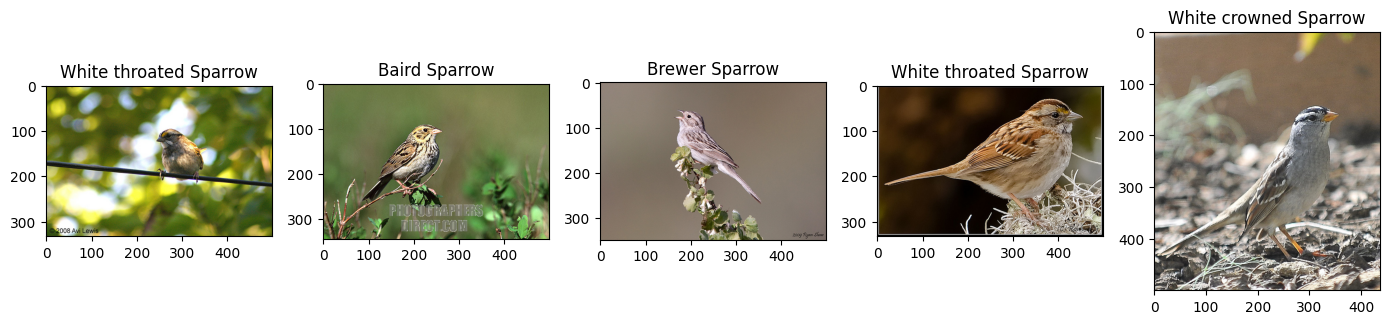

In [ ]:
random.seed(RANDOM_SEED)
in_dir_img = os.path.join(in_dir_data, 'images')

# obtain classes of sparrow species
img_sparrows = dict()
cls_sparrows_total = [k for k in os.listdir(in_dir_img) if 'sparrow' in k.lower()]

# get images of some sparrow classes 
cls_sparrows = cls_sparrows_total[1::2][:5]
for dirname in cls_sparrows:
    imgs = list()
    for dp, _, fn in os.walk(os.path.join(in_dir_img, dirname)):
        imgs.extend(fn)
    img_sparrows[dirname] = imgs

# visualize randomly-chosen images
n_cls = len(cls_sparrows)
f, ax = plt.subplots(1, n_cls, figsize=(14, 8))

for i in range(n_cls):
    cls_name = cls_sparrows[random.randint(0, n_cls - 1)]
    n_img = len(img_sparrows[cls_name])
    img_name = img_sparrows[cls_name][random.randint(0, n_img - 1)]
    path_img = os.path.join(os.path.join(in_dir_img, cls_name), img_name)
    ax[i].imshow(mpimg.imread(path_img))
    ax[i].set_title(cls_name.split('.')[-1].replace('_', ' '),  fontsize=12)

    plt.tight_layout()
plt.show()

In [ ]:
ds = tv.datasets.ImageFolder(in_dir_img)
print(ds)


Dataset ImageFolder
    Number of datapoints: 11788
    Root location: /content/drive/MyDrive/CS391L/CUB_200_2011/images


In [ ]:
def pad(img, fill=0, size_max=500):
    """
    Pads images to the specified size (height x width). 
    Fills up the padded area with value(s) passed to the `fill` parameter. 
    """
    pad_height = max(0, size_max - img.height) #img.height  shape[1]
    pad_width = max(0, size_max - img.width)   #img.width   shape[2]
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)


In [ ]:
class DatasetBirds(tv.datasets.ImageFolder):
    """
    Wrapper for the CUB-200-2011 dataset. 
    Method DatasetBirds.__getitem__() returns tuple of image and its corresponding label.    
    """
    def __init__(self,
                 root,
                 transform=None,
                 target_transform=None,
                 loader=tv.datasets.folder.default_loader,
                 is_valid_file=None,
                 train=True,
                 bboxes=False):

        img_root = os.path.join(root, 'images')

        super(DatasetBirds, self).__init__(
            root=img_root,
            transform=None,
            target_transform=None,
            loader=loader,
            is_valid_file=is_valid_file,
        )

        self.transform_ = transform
        self.target_transform_ = target_transform
        self.train = train
        
        # obtain sample ids filtered by split
        path_to_splits = os.path.join(root, 'train_test_split.txt')
        indices_to_use = list()
        with open(path_to_splits, 'r') as in_file:
            for line in in_file:
                idx, use_train = line.strip('\n').split(' ', 2)
                if bool(int(use_train)) == self.train:
                    indices_to_use.append(int(idx))

        # obtain filenames of images
        path_to_index = os.path.join(root, 'images.txt')
        filenames_to_use = list()
        with open(path_to_index, 'r') as in_file:
            for line in in_file:
                idx, fn = line.strip('\n').split(' ', 2)
                #print(fn)
                if int(idx) in indices_to_use:
                    filenames_to_use.append(fn)
        
        # print(self.imgs)
        # dict,  key: img_path,   value: idx
        img_paths_cut = {'/'.join(img_path.rsplit('/', 2)[-2:]): idx for idx, (img_path, lb) in enumerate(self.imgs)}#self.imgs
        # print(img_paths_cut)
        imgs_to_use = [self.imgs[img_paths_cut[fn]] for fn in filenames_to_use]
#         print(imgs_to_use[0])
#         print(imgs_to_use[1])

        _, targets_to_use = list(zip(*imgs_to_use))

        self.imgs = self.samples = imgs_to_use
        self.targets = targets_to_use

        if bboxes:
            # get coordinates of a bounding box
            path_to_bboxes = os.path.join(root, 'bounding_boxes.txt')
            bounding_boxes = list()
            with open(path_to_bboxes, 'r') as in_file:
                for line in in_file:
                    idx, x, y, w, h = map(lambda x: float(x), line.strip('\n').split(' '))
                    if int(idx) in indices_to_use:
                        bounding_boxes.append((x, y, w, h))

            self.bboxes = bounding_boxes
        else:
            self.bboxes = None
            
        ########################################
        ## Attributes
        ########################################
        in_dir_attributes = os.path.join(in_dir_data, 'attributes')
        path_to_attributes = os.path.join(in_dir_attributes, 'image_attribute_labels.txt')
        attributes_dict = {}
        with open(path_to_attributes, 'r') as in_file:
            for line in in_file:
                idx, attr_id, attr_present, _, _ = line.strip('\n').split(' ',4)
                idx = int(idx)
                attr_present = int(attr_present)
                if idx in indices_to_use:
                    if idx not in attributes_dict:
                        attributes_dict[idx] = [attr_present]
                    else:
                        attributes_dict[idx].append(attr_present)

        self.attributes = [attributes_dict[idx] for idx in sorted(attributes_dict.keys())]
        

    def __getitem__(self, index):
        # generate one sample
        sample, target = super(DatasetBirds, self).__getitem__(index)

        if self.bboxes is not None:
            # squeeze coordinates of the bounding box to range [0, 1]
            width, height = sample.width, sample.height
            x, y, w, h = self.bboxes[index]

            scale_resize = 500 / width
            scale_resize_crop = scale_resize * (375 / 500)

            x_rel = scale_resize_crop * x / 375
            y_rel = scale_resize_crop * y / 375
            w_rel = scale_resize_crop * w / 375
            h_rel = scale_resize_crop * h / 375

            target = torch.tensor([target, x_rel, y_rel, w_rel, h_rel]).to(DEVICE)

        if self.transform_ is not None:
            sample = self.transform_(sample)
        if self.target_transform_ is not None:
            target = self.target_transform_(target)
            
        attributes = torch.tensor(self.attributes[index]).to(DEVICE)

        return sample, attributes, target

In [ ]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))
# pad images to 500 pixels
max_padding = tv.transforms.Lambda(lambda x: pad(x, fill=fill))

In [ ]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))

# transform images
transforms_train = tv.transforms.Compose([
   max_padding,
   tv.transforms.RandomOrder([
       tv.transforms.RandomCrop((375, 375)),
       tv.transforms.RandomHorizontalFlip(),
       tv.transforms.RandomVerticalFlip()
   ]),
   # tv.transforms.Resize((375, 375)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_eval = tv.transforms.Compose([
   max_padding,
   tv.transforms.CenterCrop((375, 375)),
   # tv.transforms.Resize((375, 375)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# only keep the top 10 classes
top_10_classes = [199, 198, 197,196, 194, 193, 192, 191, 190, 188]
def filter_top_10_classes(data: torch.utils.data.Dataset):
    indices_to_keep = []
    for i in range(len(data)):
        label = data[i][2]
        if label in top_10_classes:
            indices_to_keep.append(i)
    return torch.utils.data.Subset(data, indices_to_keep)

In [ ]:
# instantiate dataset objects according to the pre-defined splits
ds_train = DatasetBirds(in_dir_data, transform=transforms_train, train=True)
ds_val = DatasetBirds(in_dir_data, transform=transforms_eval, train=True)
ds_test = DatasetBirds(in_dir_data, transform=transforms_eval, train=False)

# splits = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
# idx_train, idx_val = next(splits.split(np.zeros(len(ds_train_filtered)), ds_train_filtered.targets))

In [ ]:
# keep top 10 classes
ds_train_filtered = filter_top_10_classes(ds_train)
ds_val_filtered = filter_top_10_classes(ds_val)
ds_test_filtered = filter_top_10_classes(ds_test)


In [ ]:
original_targets = ds_train.targets
filtered_indices = ds_train_filtered.indices
filtered_targets = [original_targets[i] for i in filtered_indices]
splits = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
idx_train, idx_val = next(splits.split(np.zeros(len(ds_train_filtered)), filtered_targets))


In [ ]:
# set hyper-parameters
params = {'batch_size': 24}
num_epochs = 100
num_classes = 200

In [ ]:
# instantiate data loaders
train_loader = td.DataLoader(
   dataset=ds_train_filtered,
   sampler=td.SubsetRandomSampler(idx_train),
   **params
)
val_loader = td.DataLoader(
   dataset=ds_val_filtered,
   sampler=td.SubsetRandomSampler(idx_val),
   **params
)
test_loader = td.DataLoader(dataset=ds_test_filtered, **params)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.notebook import tqdm

In [ ]:
class BirdsCNN(nn.Module):
    def __init__(self, image_feature_dim, attribute_dim, num_classes):
        super(BirdsCNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(43264, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

## Training the base image model

In [ ]:
# Create the cnn model
image_feature_dim = 375 * 375 * 3
attribute_dim = len(ds_train_filtered[0][1])
num_classes = 200
model = BirdsCNN(image_feature_dim, attribute_dim, num_classes).to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    model.train()
    i=0
    for images, attributes, targets in train_loader:
        i+=1
        images = torch.tensor(images).to(DEVICE)  #torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
        targets = torch.tensor(targets).to(torch.long).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).to(torch.float32)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # Validate the model
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, attributes, targets in val_loader:
            images = torch.tensor(images).to(DEVICE) # torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
            attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
            targets = torch.tensor(targets).to(torch.long).to(DEVICE)

            outputs = model(images).to(torch.float32)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 *correct / total}%')

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-43-7ac3ecdfb744>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE)  #torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
<ipython-input-43-7ac3ecdfb744>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Epoch [1/20], Step [10/12], Loss: 3.397777557373047


<ipython-input-43-7ac3ecdfb744>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE) # torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
<ipython-input-43-7ac3ecdfb744>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
<ipython-input-43-7ac3ecdfb744>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Epoch [1/20], Validation Accuracy: 10.0%
Epoch [2/20], Step [10/12], Loss: 2.668992280960083
Epoch [2/20], Validation Accuracy: 10.0%
Epoch [3/20], Step [10/12], Loss: 2.283287286758423
Epoch [3/20], Validation Accuracy: 10.0%
Epoch [4/20], Step [10/12], Loss: 2.29819393157959
Epoch [4/20], Validation Accuracy: 13.333333333333334%
Epoch [5/20], Step [10/12], Loss: 2.2756669521331787
Epoch [5/20], Validation Accuracy: 13.333333333333334%
Epoch [6/20], Step [10/12], Loss: 2.3495709896087646
Epoch [6/20], Validation Accuracy: 20.0%
Epoch [7/20], Step [10/12], Loss: 2.1393520832061768
Epoch [7/20], Validation Accuracy: 20.0%
Epoch [8/20], Step [10/12], Loss: 2.3550946712493896
Epoch [8/20], Validation Accuracy: 23.333333333333332%
Epoch [9/20], Step [10/12], Loss: 2.14703106880188
Epoch [9/20], Validation Accuracy: 16.666666666666668%
Epoch [10/20], Step [10/12], Loss: 2.218855857849121
Epoch [10/20], Validation Accuracy: 23.333333333333332%
Epoch [11/20], Step [10/12], Loss: 1.96907997131

In [ ]:
with torch.no_grad():
    total = 0
    correct = 0
    for images, attributes, targets in test_loader:
        images = torch.tensor(images).to(DEVICE)# torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
        attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
        targets = torch.tensor(targets).to(torch.long).to(DEVICE)

        outputs = model(images).to(torch.float32)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Test Accuracy: {100 *correct / total}%')

<ipython-input-44-e5278c6a50c3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE)# torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
<ipython-input-44-e5278c6a50c3>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
<ipython-input-44-e5278c6a50c3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Test Accuracy: 31.666666666666668%


## Training the late fusion model


In [ ]:
class LateFusion(nn.Module):
    def __init__(self, image_feature_dim, attribute_dim, num_classes):
        super(LateFusion, self).__init__()

        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(43264, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        self.attribute_encoder =  nn.Sequential(
            nn.Linear(attribute_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, image, attributes):
        image_features = self.image_encoder(image)        
        attribute_features = self.attribute_encoder(attributes)
        image_features = torch.unsqueeze(image_features, dim=1)
        attribute_features = torch.unsqueeze(attribute_features, dim=1)
        combined_features = torch.concat([image_features, attribute_features], dim = 1)
        averaged_features = torch.mean(combined_features, dim = 1)
        return averaged_features

In [ ]:
# Create the cnn model
image_feature_dim = 375 * 375 * 3
attribute_dim = len(ds_train_filtered[0][1])
num_classes = 200
model = LateFusion(image_feature_dim, attribute_dim, num_classes).to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    model.train()
    i=0
    for images, attributes, targets in train_loader:
        i+=1
        images = torch.tensor(images).to(DEVICE) #torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
        attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
        targets = torch.tensor(targets).to(torch.long).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images, attributes).to(torch.float32).to(DEVICE)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    #Validate the model
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, attributes, targets in val_loader:
            images = torch.tensor(images).to(DEVICE) # torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
            attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
            targets = torch.tensor(targets).to(torch.long).to(DEVICE)

            outputs = model(images,attributes).to(torch.float32).to(DEVICE)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 *correct / total}%')

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-117-a654bec7b768>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE) #torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
<ipython-input-117-a654bec7b768>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
<ipython-input-117-a654bec7b768>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Epoch [1/20], Step [10/12], Loss: 2.6754376888275146


<ipython-input-117-a654bec7b768>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE) # torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
<ipython-input-117-a654bec7b768>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
<ipython-input-117-a654bec7b768>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Epoch [1/20], Validation Accuracy: 13.333333333333334%
Epoch [2/20], Step [10/12], Loss: 2.4097542762756348
Epoch [2/20], Validation Accuracy: 10.0%
Epoch [3/20], Step [10/12], Loss: 2.466304063796997
Epoch [3/20], Validation Accuracy: 23.333333333333332%
Epoch [4/20], Step [10/12], Loss: 2.217491865158081
Epoch [4/20], Validation Accuracy: 36.666666666666664%
Epoch [5/20], Step [10/12], Loss: 2.2274646759033203
Epoch [5/20], Validation Accuracy: 36.666666666666664%
Epoch [6/20], Step [10/12], Loss: 2.1198697090148926
Epoch [6/20], Validation Accuracy: 23.333333333333332%
Epoch [7/20], Step [10/12], Loss: 2.150731086730957
Epoch [7/20], Validation Accuracy: 46.666666666666664%
Epoch [8/20], Step [10/12], Loss: 1.9383419752120972
Epoch [8/20], Validation Accuracy: 30.0%
Epoch [9/20], Step [10/12], Loss: 2.075261354446411
Epoch [9/20], Validation Accuracy: 36.666666666666664%
Epoch [10/20], Step [10/12], Loss: 2.0018160343170166
Epoch [10/20], Validation Accuracy: 33.333333333333336%
Epo

In [ ]:
with torch.no_grad():
    total = 0
    correct = 0
    for images, attributes, targets in test_loader:
        images = torch.tensor(images).to(DEVICE)# torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
        attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
        targets = torch.tensor(targets).to(torch.long).to(DEVICE)

        outputs = model(images, attributes).to(torch.float32)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Test Accuracy: {100 *correct / total}%')

<ipython-input-119-bc5dcb52b6ce>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE)# torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
<ipython-input-119-bc5dcb52b6ce>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
<ipython-input-119-bc5dcb52b6ce>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Test Accuracy: 45.666666666666664%
